# Similar cities analysis with GANs: Discriminator

This notebook focuses on the discriminator model in the GAN formulation. This model has learned feature maps that are good to distinguish real from synthetic cities. The Analyzer feature maps should also be useful to recover high-level spatial statistics, so we use the last layer in that module as well. 

We focus on the following questions:
* can we build a network of "similarity" in the spatial distributions of population/luminosity/built areas
* can we find communities in this network?

# Packages

In [1]:
import numpy as np
import pandas as pd

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave

import warnings
warnings.filterwarnings('ignore')

import gzip
import cPickle as pickle
import copy

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable, grad
import torchvision.transforms as transforms

sys.path.append("../models/pytorch-CycleGAN-and-pix2pix/")

from models.models import create_model
from data.data_loader import CreateDataLoader
from util.visualizer import Visualizer
from pdb import set_trace as st
from util import html

sys.path.append("../pytorch_utils")
from loader_dataframe import ImageDataFrame, fn_rotate, grayscale_loader, default_loader

# Load model to analyze

#### Parse options file to load model parameters

In [3]:
def parse_value(v):
    try:
        v = float(v)
        if np.isinf(v):
            return v
        if np.round(v,0)==v:
            v = int(v)
        return v
    except:
        pass

    if v == 'False':
        return False
    elif v == 'True':
        return True
    elif '|' in v:
        v = v.split("|")
    elif v == '[]':
        v = []
    elif '[' in v:
        v = [int(x) if "'" not in x and '"' not in x else x.replace("'","").replace('"',"") \
             for x in v[1:-1].split(", ")]
    else:
        pass
    return v

from collections import namedtuple

def parse_opt_file(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
    lines = [tuple(l.replace("\n","").split(': ')) for l in lines[1:-1]] 
    lines = [(x[0], parse_value(x[1])) for x in lines]
    ret = namedtuple("opt", [l[0].strip() for l in lines])
    for l in lines:
        setattr(ret, l[0], l[1])
    return ret

In [112]:
checkpoints_path = "/home/data/pytorch-workspace/urban-form-checkpoints/"

experiment_path = "pix2pix_reg_bceloss_af_nowater"

output_path = checkpoints_path + "checkpoints/" + experiment_path 

In [84]:
opt_filename = output_path + "/opt.txt"

opt = parse_opt_file(opt_filename)
opt.checkpoints_dir = checkpoints_path + opt.checkpoints_dir
opt.batchSize = 1
if opt.label_columns == "":
    opt.label_columns = []
if hasattr(opt, 'cond_columns') and opt.cond_columns == "":
    opt.cond_columns = []
    
opt.nThreads = 1   # test code only supports nThreads=1
opt.batchSize = 8  #test code only supports batchSize=1
opt.serial_batches = True # no shuffle
# opt.gpu_ids = '-1'
opt.noise_amt = 0.01

#### Load models G and D

In [85]:
opt.phase = "test"
opt.which_epoch = 'latest'

model = create_model(opt)

model.load_network(model.netD, 'D', opt.which_epoch)

pix2pix-reg
---------- Networks initialized -------------
UnetGenerator (
  (model): UnetSkipConnectionBlock (
    (model): Sequential (
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): UnetSkipConnectionBlock (
        (model): Sequential (
          (0): LeakyReLU (0.2, inplace)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
          (3): UnetSkipConnectionBlock (
            (model): Sequential (
              (0): LeakyReLU (0.2, inplace)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
              (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
              (3): UnetSkipConnectionBlock (
                (model): Sequential (
                  (0): LeakyReLU (0.2, inplace)
                  (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
                  (2

In [7]:
opt.dataroot

'/home/data/world-cities/top10k-log/'

#### Set up data loader

In [154]:
train_df = pd.read_csv(opt.dataroot + "train.csv").drop("Unnamed: 0", 1)
test_df  = pd.read_csv(opt.dataroot + "test.csv").drop("Unnamed: 0", 1)
valid_df = pd.read_csv(opt.dataroot + "valid.csv").drop("Unnamed: 0", 1)

df = pd.concat([train_df, test_df], axis=0).reset_index().drop("index",1)
df.to_csv(opt.dataroot + "all_sources.csv", index=False)

df.shape

(9916, 26)

In [206]:
opt.phase = 'all_sources'
data_loader = CreateDataLoader(opt)
dataset = data_loader.load_data()

opt.phase = 'valid'
data_loader_valid = CreateDataLoader(opt)
dataset_valid = data_loader_valid.load_data()

visualizer = Visualizer(opt)


AlignedDataLoaderCSV
loading from file /home/data/world-cities/top10k-log//all_sources.csv
AlignedDataLoaderCSV
loading from file /home/data/world-cities/top10k-log//valid.csv
create web directory /home/data/pytorch-workspace/urban-form-checkpoints/./checkpoints/pix2pix_reg_bceloss_af_nowater/web...


In [203]:
# valid_df['filename_SAR'] = valid_df['filename_SAR'].apply(lambda x: x.replace("_pruned/", "_pruned_log/"))
# valid_df['filename_PNM'] = valid_df['filename_PNM'].apply(lambda x: x.replace("_pruned/", "_pruned_log/"))
# valid_df.to_csv(opt.dataroot + "valid.csv")

# Extract features for validation set cities

In [92]:
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        self.features_analyzer = nn.Sequential(
            *list(original_model.classifier_cls.children())[:-3]
        )
        self.features = original_model.features
        self.flat_fts = original_model.flat_fts
        self.gpu_ids  = original_model.gpu_ids
        
    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and len(self.gpu_ids)> 1:
            fts = nn.parallel.data_parallel(self.features, input, self.gpu_ids)
            base_fts = fts.view(-1, self.flat_fts)
            anal_fts = nn.parallel.data_parallel(self.features_analyzer, base_fts, self.gpu_ids)           
        else: 
            fts = self.features(input)
            base_fts = fts.view(-1, self.flat_fts)
            anal_fts= self.features_analyzer(base_fts)
        out_fts = torch.cat([base_fts, anal_fts], 1)
        return out_fts

feature_extractor = FeatureExtractor(model.netD)

In [207]:
features = []
for i, data in enumerate(dataset_valid):
    clear_output(wait=True)
    print "batch %d / %d" % (i, len(df) / opt.batchSize)
    feature_extractor.zero_grad()
    model.set_input(data)
    batch_size = model.input_A.size()[0]
    AtoB = model.opt.which_direction == 'AtoB'
    real_A = Variable(model.input_A, requires_grad=AtoB)
    real_B = Variable(model.input_B, requires_grad=not AtoB)
    real_AB = torch.cat((real_A, real_B), 1)#.detach()
    feat_batch = feature_extractor(real_AB)
    feat_batch = feat_batch.data.cpu().numpy().reshape((batch_size,-1))
    features.append(feat_batch)
    
features = np.vstack(features)

batch 374 / 1239


In [208]:
features.shape

(2996, 950)

In [209]:
import cPickle as pickle
import gzip

with gzip.open(output_path + "/valid_features.pickle.gz", "w") as f:
    pickle.dump(features, f)

# Build a nearest-neighbor classifier for cities

In [217]:
from scipy.spatial import cKDTree
from sklearn.neighbors import KDTree, BallTree

nfeats = 950
myfeatures = features[:,:nfeats] # feats_tsne
my_df = valid_df

tree = BallTree(myfeatures, leaf_size=100)

In [221]:
mycities = ["san francisco, us", "paris, fr", "boston, us", "lagos, ng"]
sel_df = my_df[my_df['city'].apply(lambda s: sum([x in s for x in mycities])>0)]

feats_sel = myfeatures[sel_df.index,:]

n_examples = 4
_, neighbors = tree.query(feats_sel, k=n_examples, dualtree=True)

In [222]:
from skimage.io import imread, imsave
from skimage.transform import resize

# create canvass
canvass = []
for city0,f0,idx in zip(sel_df['city'], sel_df['filename_PNM'], neighbors):
    img0 = imread(f0)
    # imsave(experiment_dir + "./example_%s"%city0, img0)
    row = [np.pad(resize(img0, (100,100)), (2,2), "constant")]
    for _,r in my_df.ix[idx[1:]].iterrows():
        img = imread(r['filename_PNM'])
        row.append(np.pad(resize(img, (100,100)), (2,2), "constant"))
    canvass.append(np.hstack(row))
canvass = np.vstack(canvass)

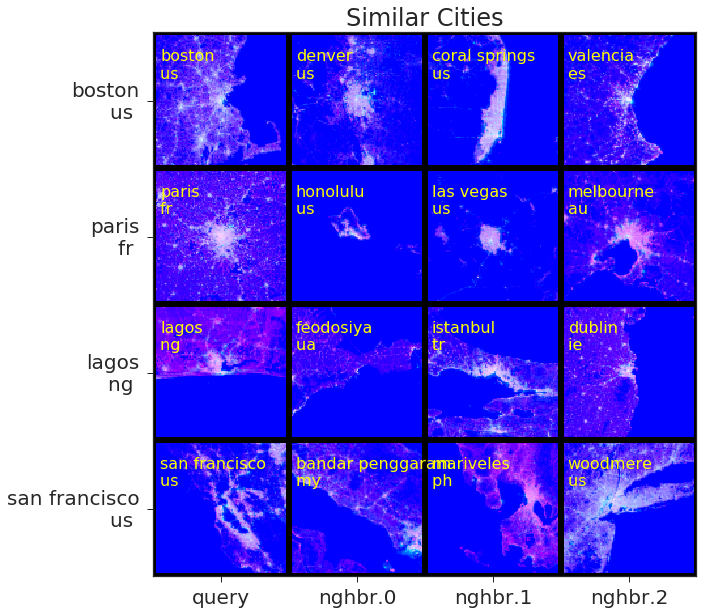

In [223]:
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1})

# plot
plt.figure(figsize=(24,10))
plt.imshow(canvass[:,:,2:5])
plt.yticks([])
plt.yticks([52 + i * 104 for i in range(len(sel_df))], [x.split("(")[0].replace(", ", "\n") for x in sel_df['city']])
plt.xticks([52 + i * 104 for i in range(n_examples)], ["query"] + ["nghbr.%d"%i for i in range(n_examples)])
plt.title("Similar Cities")

for i,(city0,f0,idx) in enumerate(zip(sel_df['city'], sel_df['filename_SAR'], neighbors)):
    for j,(_,r) in enumerate(my_df.ix[idx].iterrows()):
        city1 = r['city']
        plt.annotate(city1.split("(")[0].replace(", ", "\n"), 
                     xy=(5 + j * 104, 35 + i * 104), 
                     xytext=(5 + j * 104, 35 + i * 104),
                     fontsize=16, color="yellow")

# Find groups of similar cities

### Build network of "neighboring cities"

In [331]:
A = np.zeros((len(my_df), len(my_df)))

all_cities = my_df['city']

for i,c in enumerate(all_cities):
    clear_output(wait=True)
    print i, '/', len(all_cities)
    dist, neighbors = tree.query([myfeatures[i,:]], k=10)
    A[i,neighbors[0]] = dist[0]

2995 / 2996


In [332]:
float((A>0).sum()) / (A.shape[0]*A.shape[1])

0.0030040053404539386

In [333]:
edge_weights = [1.0/(A[i,j]+1) for j in range(A.shape[1]) \
                for i in range(A.shape[0]) if A[i,j]>0]
edge_links = [(i,j) for j in range(A.shape[1]) \
                for i in range(A.shape[0]) if A[i,j]>0]

### Find communities in neighbor network

In [334]:
import igraph

g = igraph.Graph(edges=edge_links, directed=True)
communities = g.community_leading_eigenvector(weights=edge_weights)

In [335]:
communities.membership
part = {}
for co in range(len(communities.membership)):
    part[co] = communities.membership[co]

In [336]:
from collections import Counter
from operator import itemgetter
import operator
from collections import defaultdict
import networkx as nx
import matplotlib

(-0.5, 2995.5, 2995.5, -0.5)

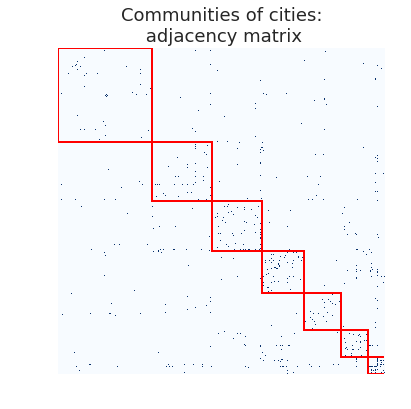

In [337]:
GG = nx.Graph()
GG.add_edges_from(edge_links)

vettore_ordine=[]
for ke,va in Counter(part.values()).iteritems():
    vettore_ordine.append([ke,va])
vettore_ordine=sorted(vettore_ordine,key=operator.itemgetter(1),reverse=True) 

new_ord=[ke[0] for ke in vettore_ordine]

part2={}
for ke, va in part.iteritems():
    part2[ke]=new_ord.index(va)

louvain_comms = defaultdict(list)
for node_index, comm_id in part2.iteritems():
    louvain_comms[comm_id].append(node_index)
louvain_comms = louvain_comms.values()

nodes_louvain_ordered = [node for comm in louvain_comms for node in comm]
#salvo=SAVEDATABANK+'transacciones/RamdomSequitur/Figure/top_zscore_big10_word_user.eps'
#salvo=None
adjacency_matrix = nx.to_numpy_matrix(GG, dtype=np.bool, nodelist=nodes_louvain_ordered)

sns.set_context("notebook", font_scale=1.5)
#sns.set(style="ticks")
#Plot adjacency matrix in toned-down black and white
fig = plt.figure(figsize=(6, 6)) # in inches
plt.imshow(adjacency_matrix,cmap="Blues", interpolation='none' )

partitions=[louvain_comms]
colors=["red"]

assert len(partitions) == len(colors)
ax = plt.gca()
for partition, color in zip(partitions, colors):
    current_idx = 0
    for module in partition:
        ax.add_patch(matplotlib.patches.Rectangle((current_idx, current_idx),
                                     len(module), # Width
                                     len(module), # Height
                                     facecolor="none",
                                     edgecolor=color,
                                     linewidth="2"))
        current_idx += len(module)
# plt.colorbar()
#ax.figure.savefig('figure/louvain_1.png')
groups=defaultdict(list)
for key,values in part2.iteritems():
    groups[values].append(key)
    
plt.title("Communities of cities:\n adjacency matrix")
plt.axis("off")

### Plot links between cities on map

In [338]:
from shapely.geometry import Point
import geopandas as gpd

my_df['loc'] = my_df['filename_SAR'].apply(
                lambda f: [float(x) for x in os.path.basename(f).replace(".png","").split("_")[-2:]][::-1])
my_gdf = gpd.GeoDataFrame(my_df.copy())
my_gdf['geometry'] = my_gdf['loc'].apply(lambda x: Point(x))
my_gdf['cluster'] = map(lambda x: part[x], my_gdf.index)

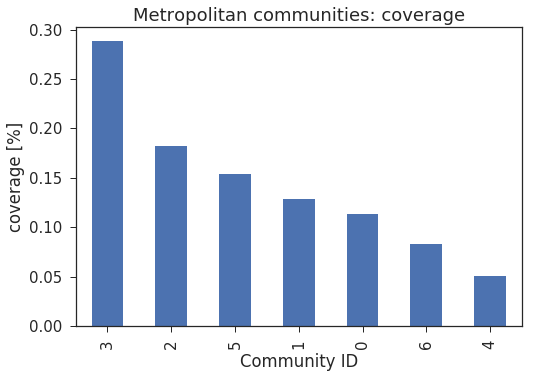

In [339]:
(my_gdf['cluster'].value_counts()/len(my_gdf)).plot(kind="bar")
plt.title("Metropolitan communities: coverage")
plt.xlabel("Community ID")
plt.ylabel("coverage [%]")

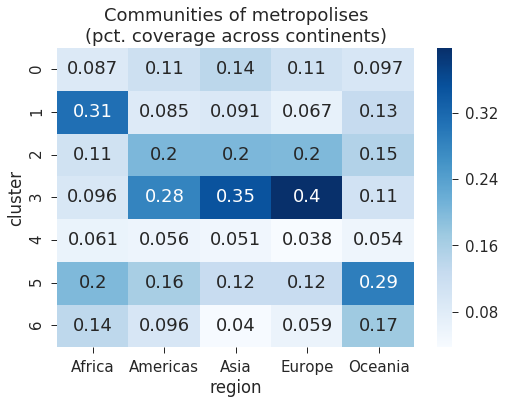

In [340]:
clust_by_region = pd.crosstab(my_gdf['cluster'], my_gdf['region'])
clust_by_region_pct = clust_by_region / clust_by_region.sum()

sns.set_context('notebook', font_scale=1.5)
sns.heatmap(clust_by_region_pct, annot=True, cmap="Blues")
plt.title("Communities of metropolises\n(pct. coverage across continents)")

In [341]:
sns.color_palette("hls", 10)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.6832, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.41279999999999994, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.5167999999999995, 0.86),
 (0.4752000000000003, 0.33999999999999997, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6207999999999999)]

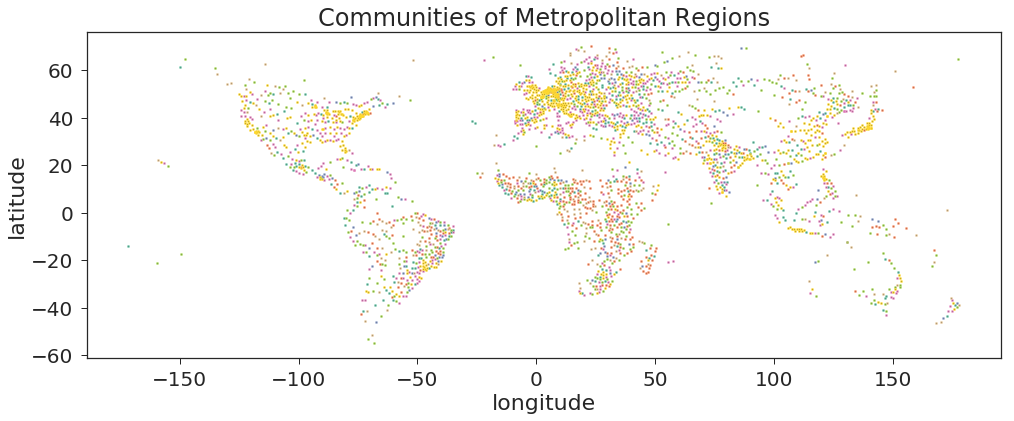

In [345]:
sns.set_context('notebook', font_scale=2)

ax = my_gdf.plot(figsize=(20,6), marker='*', color='black')
for c,col in zip(my_gdf['cluster'].unique(), sns.color_palette("Set2", 10)):
    my_gdf[my_gdf['cluster']==c].plot(ax=ax, marker='.', color=col, markersize=6, alpha=0.7)
plt.title("Communities of Metropolitan Regions")
plt.xlabel("longitude")
plt.ylabel("latitude")

In [306]:
my_gdf[['city', 'region', 'loc', 'cluster']].T.to_json("../visualization/cities.json")

In [307]:
import geojson

dat = geojson.load(open("../visualization/cities.json"))

In [309]:
dat.values()[0]

{u'city': u'paranavai, br (pop 72.8k)',
 u'cluster': 0,
 u'loc': [-52.4667, -23.0667],
 u'region': u'Americas'}